In [1]:
import numpy as np
from tqdm import tqdm
import timeit
from matplotlib import pyplot as plt
from Code import ULA
from Code import Algo1
from Code import ZVnbrosse

### Gaussian mixture 

## $\pi (x) = \frac{1}{2(2\pi)^{d/2}} \left( e ^{\frac{-| x-a|^2}{2}}  + e ^{\frac{-| x+a|^2}{2}} \right), \quad x \in\mathbb R^d$

$U(x) = \frac{1}{2} \|x - a\|_2^2 - \text{log}(1 + e^{-2x^\top a})$

$\nabla U(x) = x-a +2a(1 + e^{2 x^\top a})^{-1}$

$ m = 1 - \|a \|_2^2 \quad $ (strongly convex function)

$M = 1 \quad$  (Lipschitz continuous gradient)

$a = (\frac{1}{\sqrt{2d}}, \dots, \frac{1}{\sqrt{2d}})$

## Setup

In [2]:
dim = 2
h = 0.05
n = 2000
N_train = 50
N_test = 100
n_tilde = 50
deg = 2
def f_grad(x):
    a = np.ones(dim) / np.sqrt(2*dim)
    return x - a + 2 * a/(1 + np.exp(2* (x.T @ a)))

def local_weighted_estimator(X):
    return X.sum(axis=1).mean()

def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

### Generate sample and plot

In [3]:
np.random.seed(2342)
X, G, Z = ULA.ULA_with_burnin(d=dim, step=h, burn_in=10000, n=100000,f_grad=f_grad)

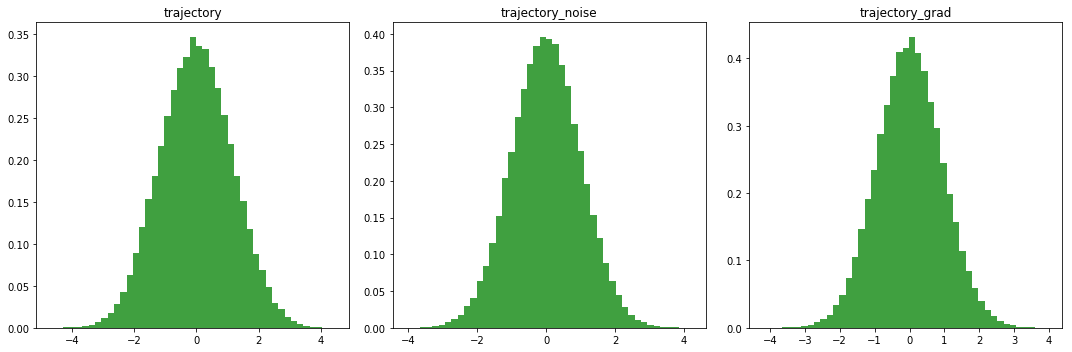

In [4]:
ULA.plot_distr(X,Z,G,0)

### Generate train ant test trajectories

In [5]:
np.random.seed(123)

XX, GG, ZZ = ULA.generate_train_trajectories(X, N_train=N_train,d = dim, step = h, n = n, f_grad=f_grad)
XX_test, GG_test, ZZ_test = ULA.generate_test_trajetories(N_test=N_test, d =dim, step=h, 
                                                          burn_in=10000, n = n, f_grad=f_grad)

### Algorithm 1 

In [9]:
Betas, degrees = Algo1.G_pml_fit_meansum(XX,max_deg = 1)

100%|██████████| 2000/2000 [00:06<00:00, 323.21it/s]


In [10]:
k_comb = np.zeros((dim,dim), dtype=np.int16)
for i in range(dim):
    k_comb[i,i] = 1

In [7]:
k_comb = np.array([[1,0], [0,1], [1,1], [2,0], [0,2]], dtype=np.int16)

### Check and time

In [14]:
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[-1])
print ("mean of target function =", p)
for i in range(len(k_comb)):
    p = p - Algo1.M_bias(k_comb[i],XX_test[-1],GG_test[-1], ZZ_test[-1], h, degrees,Betas, 100)
    print ("            (k = {}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))

mean of target function = -0.15424969311631595
            (k = [1 0]) = -0.029024910841475043 [Time:17.7563927279989]
            (k = [0 1]) = -0.01713512502843724 [Time:35.55649211599666]


## Check results on test trajectories

In [20]:
P_test = estimator(XX_test)

M_test = np.empty((len(k_comb),P_test.shape[0]))
for i in range(len(k_comb)):
    M_test[i] = Algo1.estimator_bias(k_comb[i], XX_test, GG_test, ZZ_test, h, degrees,Betas,100, n_jobs=8)

100%|██████████| 100/100 [00:00<00:00, 16726.37it/s]


In [21]:
res_zv_1 = []
for i in range (XX_test.shape[0]):
    res_zv_1.append(ZVnbrosse.ZVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim)))
res_zv_1 = np.array(res_zv_1).reshape(-1)

res_zv_2 = []
for i in range (XX_test.shape[0]):
    res_zv_2.append(ZVnbrosse.ZVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim)))
res_zv_2 = np.array(res_zv_2).reshape(-1)

res_cv_1 = []
for i in range (XX_test.shape[0]):
    res_cv_1.append(ZVnbrosse.CVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim)))
res_cv_1 = np.array(res_cv_1).reshape(-1)

res_cv_2 = []
for i in range (XX_test.shape[0]):
    res_cv_2.append(ZVnbrosse.CVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim)))
res_cv_2 = np.array(res_cv_2).reshape(-1)

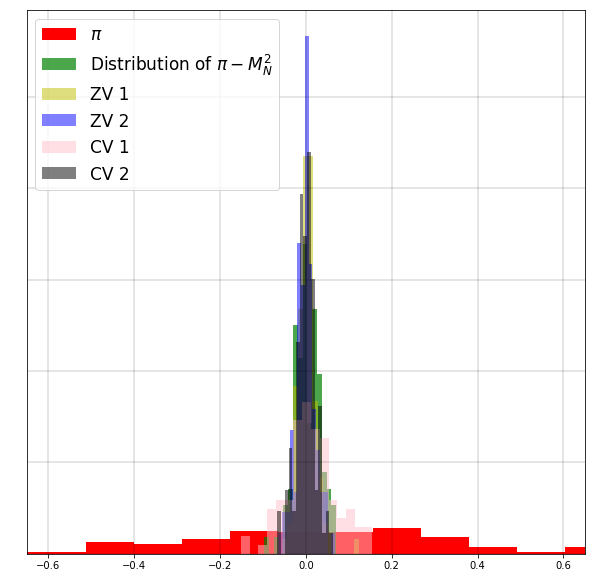

In [22]:
plt.figure(figsize=(10,10))
plt.hist(P_test,15, facecolor='r', density=True, alpha=1, label=r"$\pi$")

plt.hist((P_test-M_test.sum(axis=0)),15, density=True, facecolor='g', alpha=0.7, label="Distribution of $\pi - M^2_N$")

plt.hist(res_zv_1,15, facecolor='y', density=True, alpha=0.5, label="ZV 1")
plt.hist(res_zv_2,15, facecolor='b', density=True, alpha=0.5, label="ZV 2")
plt.hist(res_cv_1,15, facecolor='pink', density=True, alpha=0.5, label="CV 1")
plt.hist(res_cv_2,15, facecolor='black', density=True, alpha=0.5, label="CV 2")

plt.legend(loc=2, prop={'size': 17})
plt.grid(linestyle='-', linewidth=0.2, color='black')
plt.tick_params(axis='y',color = 'w', labelcolor = 'w', which='both')
plt.xlim(-0.65, 0.65)
plt.show()

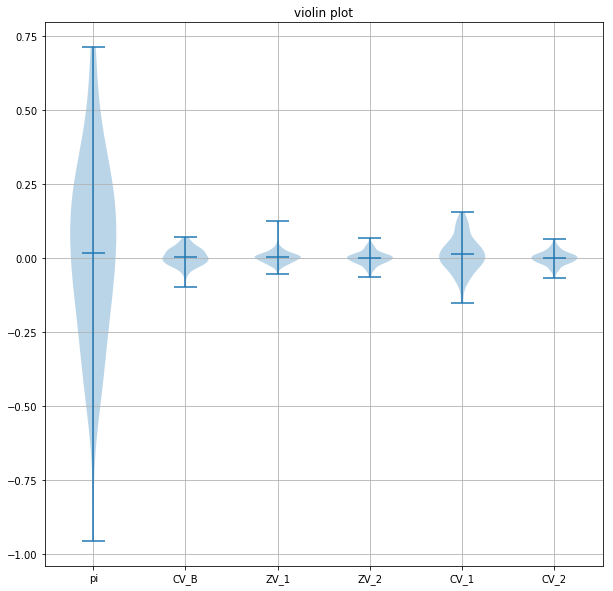

In [23]:
all_data = [P_test]
all_data.append(P_test - M_test.sum(axis = 0))
all_data.append(res_zv_1)
all_data.append(res_zv_2)
all_data.append(res_cv_1)
all_data.append(res_cv_2)
    
plt.figure(figsize=(10,10))
plt.violinplot(all_data, showmeans=True, showmedians=False)
plt.title('violin plot')
plt.xticks(np.arange(1,7), ('pi', 'CV_B', 'ZV_1', 'ZV_2', 'CV_1', 'CV_2'))
plt.grid()
plt.show()

In [24]:
print ('          Variance of Pi = ',P_test.var(ddof = 1))
for i in range(len(k_comb)):
    print ('Variance of new estimator =',(P_test-M_test[:i+1].sum(axis = 0)).var(ddof = 1))
print ('        Variance of CV 1 = ',res_cv_1.var(ddof=1))
print ('        Variance of CV 2 = ',res_cv_2.var(ddof=1))
print ('        Variance of ZV 1 = ',res_zv_1.var(ddof=1))
print ('        Variance of ZV 2 = ',res_zv_2.var(ddof=1))

          Variance of Pi =  0.09346584082284892
Variance of new estimator = 0.05762376353916486
Variance of new estimator = 0.0008765024182441952
        Variance of CV 1 =  0.003551943807257721
        Variance of CV 2 =  0.0005185289314214197
        Variance of ZV 1 =  0.00047750021175437744
        Variance of ZV 2 =  0.0005106477206570119


In [26]:
print ('VRF CVB = ',P_test.var(ddof = 1)/ (P_test - M_test.sum(axis = 0)).var(ddof=1))
print ('VRF CV1 = ',P_test.var(ddof = 1)/res_cv_1.var(ddof = 1))
print ('VRF CV2 = ',P_test.var(ddof = 1)/res_cv_2.var(ddof = 1))
print ('VRF ZV1 = ',P_test.var(ddof = 1)/res_zv_1.var(ddof = 1))
print ('VRF ZV2 = ',P_test.var(ddof = 1)/res_zv_2.var(ddof = 1))

VRF CVB =  106.63500622175029
VRF CV1 =  26.31399760093875
VRF CV2 =  180.25193033421544
VRF ZV1 =  195.73989397710898
VRF ZV2 =  183.03389409550968


In [ ]:
np.save("logs/GM_2d_M_test_(K = {}, n_tilde={}).npy".format(deg, n_tilde), M_test)